# Two Dimensions


Simulate trajectories of a particle cloud in a two-dimensional flow field.
A doubly-periodic domain and simple flow fields are used.
For additional documentation e.g. see :
[1](https://JuliaClimate.github.io/IndividualDisplacements.jl/dev/),
[2](https://JuliaClimate.github.io/MeshArrays.jl/dev/),
[3](https://docs.juliadiffeq.org/latest/solvers/ode_solve.html),
[4](https://en.wikipedia.org/wiki/Displacement_(vector))

Exercises:
- change the initial distribution of particles
- increase the duration of the trajectories simulation
- treat the non-periodic domain case by padding `u,v` with zeros
- replace `u,v` with your own two-dimensional flow fields

![particles in random flow](https://github.com/JuliaClimate/IndividualDisplacements.jl/raw/master/examples/figs/RandomFlow.gif)

## 1. Import Software

In [1]:
using IndividualDisplacements, DataFrames
p=dirname(pathof(IndividualDisplacements))
include(joinpath(p,"../examples/flow_fields.jl"));

## 2. Flow Fields

Let's start with a simple, doubly periodic flow field defined by a streamfunction
and create the `FlowFields` data structure which will then be drive the
individual displacement and trajectory computations

In [2]:
nx=16
dx= π/nx
XC = dx*(collect(1:2*nx) .- 0.5)
YC = dx*(collect(1:nx) .- 0.5)

fac=0.1
f(x, y) = sin(x) + cos(y) #streamfunction
ϕ = fac*[f(x, y) for x in XC,y in YC] #streamfunction
uC = -fac*[sin(y) for x in XC,y in YC] #dphi/dy at cell center
vC = -fac*[cos(x) for x in XC,y in YC]; #-dphi/dx at cell center

When starting as done here with collocated velocities in m/s units (`uC,vC` at
the grid cell center), one easily obtains the normalized, staggered C-grid
velocities (`u,v`) as shown below.
`u` (resp `v`) is staggered by `-0.5` grid point in direction `1` for `u` (`2` for `v`)
from the grid cell center `uC,vC`. This staggering of variables as well as the
normalization of velocities by the grid scale are key conventions
adopted in `IndividualDisplacements.jl`.

In [3]:
u=0.5*(circshift(uC, (1,0))+uC) /dx #staggered u converted to grid point units (m/s -> 1/s)
v=0.5*(circshift(vC, (0,1))+vC) /dx #staggered v converted to grid point units (m/s -> 1/s)

𝐹=FlowFields(u,u,v,v,[0.,10.])

𝐹_Array2D{Float64}([-0.04991971965178092 -0.14784077212442612 … -0.14784077212442615 -0.04991971965178104; -0.04991971965178092 -0.14784077212442612 … -0.14784077212442615 -0.04991971965178104; … ; -0.04991971965178092 -0.14784077212442612 … -0.14784077212442615 -0.04991971965178104; -0.04991971965178092 -0.14784077212442612 … -0.14784077212442615 -0.04991971965178104], [-0.04991971965178092 -0.14784077212442612 … -0.14784077212442615 -0.04991971965178104; -0.04991971965178092 -0.14784077212442612 … -0.14784077212442615 -0.04991971965178104; … ; -0.04991971965178092 -0.14784077212442612 … -0.14784077212442615 -0.04991971965178104; -0.04991971965178092 -0.14784077212442612 … -0.14784077212442615 -0.04991971965178104], [-0.5068434193261981 -0.5068434193261981 … -0.5068434193261981 -0.5068434193261981; -0.48736571096255654 -0.48736571096255654 … -0.48736571096255654 -0.48736571096255654; … ; -0.48736571096255654 -0.48736571096255654 … -0.48736571096255654 -0.48736571096255654; -0.50684341

## 3. Initialize Individuals

For example, we can initialize 100 particles within a central subdomain as follows.

In [4]:
np,nq=size(u)
x=np*(0.4 .+ 0.2*rand(100))
y=nq*(0.4 .+ 0.2*rand(100));

The following constructor function wraps everything in the `Individuals` data structure.

In [5]:
𝐼=Individuals(𝐹,x,y)

  📌 details     = (1, 100) Vector{Float64}
  🔴 details     = (0, 4) ["ID", "x", "y", "t"]
  🆔 range       = (1, 100)
  🚄 function    = dxdt!
  ∫  function    = default_solver
  🔧 function    = postprocess_xy
  𝑃  details     = (:u0, :u1, :v0, :v1, :𝑇)


## 4. Compute Trajectories

The time period is `𝐼.𝑃.𝑇` by default, unless `∫!(𝐼,𝑇)` is called instead.

In [6]:
∫!(𝐼)

1×100 Matrix{Vector{Float64}}:
 [10.5675, 13.1337]  [11.9928, 12.2258]  …  [13.6979, 13.353]

## 5. Plot Results

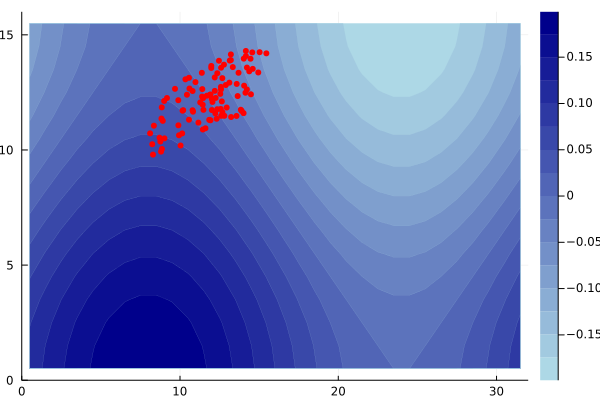

In [7]:
p=dirname(pathof(IndividualDisplacements))
include(joinpath(p,"../examples/recipes_plots.jl"));

🔴_by_t = groupby(𝐼.🔴, :t)
phi_scatter(ϕ,🔴_by_t[end])

Or to generate a simple animation:

```
anim = @animate for t in eachindex(🔴_by_t)
   phi_scatter(ϕ,🔴_by_t[t])
end

pth=tempdir()*"/"
gif(anim, pth*"RandomFlow.gif", fps = 10)
```

## 6. Alternatives (optional)

Making the flow field time variable simply involves providing two different
flow fields. Linear interpolation will then be applied in the specified time
range. For example :

```
𝐹=FlowFields(-u,u,-v,v,[0.,10.])
```

It is often convenient to set up `FlowFields` using the MeshArrays.jl package, which
handles such staggered grids in general fashion, instead of plain Arrays. Given a doubly
periodic flow field defined as before this is readily done via the `convert_to_FlowFields` function.

```
u,v,ϕ=random_flow_field()
#𝐹=FlowFields(u,u,v,v,[0.,10.])
𝐹=convert_to_FlowFields(u,v,10.0);
```

We should note that `u,v` derive from streamfunction `ϕ` which is defined at the corner point in `random_flow_field`.
Doing this ensures that the resulting `u,v` is non-divergent / purely-rotational over the C-grid domain. In brief:

```
u=-(circshift(ϕ, (0,-1))-ϕ)
v=(circshift(ϕ, (-1,0))-ϕ)
```

In contrast uC, vC computed as earlier in this example may contain contain both
[rotational and divergent](https://en.wikipedia.org/wiki/Helmholtz_decomposition)
components -- if this were an important consideration, `MeshArrays.jl` provides
tools that can be used to e.g. ensure non-divergence.

When using `MeshArray` flow fields instead of plain `Array` flow fields, initial
positions also include a subdomain array index (`a`;  all ones in our example).

```
a=ones(size(x))
#isa(𝐹,𝐹_MeshArray2D)
𝐼=Individuals(𝐹,x,y,a)
```

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*